In [7]:
import sys
import os
sys.path.insert(0, os.getcwd()+'/src/')
sys.path.insert(0, '/home/mcarenso/code/stage-2023-multiscale-extremes/scripts/src/')
from myImports import *
%matplotlib inline
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [37]:
stringSST = "300" ##295, 300 or 305
n_days = 25
chunk_size = {'time' :48, 'x' : 32, 'y' : 32}
label_chunk_size = {'time' :48, 'longitude' : 32, 'latitude' : 32}
sim = 'ICON'

if sim == "SAM" :     
    file_seg='/bdd/MT_WORKSPACE/MCS/RCE/SAM/TOOCAN/TOOCAN_v2023_05/Dspread0K/irtb/TOOCAN_2.07_SAM_large300_2D_irtb.nc'
    file_tracking='/bdd/MT_WORKSPACE/MCS/RCE/SAM/TOOCAN/TOOCAN_v2023_05/Dspread0K/irtb/FileTracking/TOOCAN-SAM_large300_2D_irtb.dat.gz'
    sim_path = "/bdd/MT_WORKSPACE/MCS/RCE/SAM/INPUTS/v2023_05/SAM_RCE_large300_2D_pr.nc"
    output_path = "/homedata/mcarenso/Stage2023/SAM/"+stringSST+"K/"
    
elif sim == "MESONH":
    file_seg='/bdd/MT_WORKSPACE/MCS/RCE/MESONH/TOOCAN/TOOCAN_v2023_05/Dspread0K/irtb/TOOCAN_2.07_MESONH_large300_2D_irtb.nc'
    file_tracking='/bdd/MT_WORKSPACE/MCS/RCE/MESONH/TOOCAN/TOOCAN_v2023_05/Dspread0K/irtb/FileTracking/TOOCAN-MESONH_large300_2D_irtb.dat.gz'
    sim_path = '/bdd/MT_WORKSPACE/MCS/RCE/MESONH/INPUTS/v2023_05/MESONH_RCE_large300_2D_pr.nc'
    output_path = "/homedata/mcarenso/Stage2023/MESONH/"+stringSST+"K/"

elif sim == "ICON":
    file_seg = '/bdd/MT_WORKSPACE/MCS/RCE/ICON/TOOCAN/TOOCAN_v2023_05/Dspread0K/irtb/TOOCAN_2.07_ICON_large300_2D_irtb.nc'
    file_tracking = '/bdd/MT_WORKSPACE/MCS/RCE/ICON/TOOCAN/TOOCAN_v2023_05/Dspread0K/irtb/FileTracking/TOOCAN-ICON_large300_2D_irtb.dat.gz' #'/bdd/MT_WORKSPACE/MCS/RCE/ICON/TOOCAN/TOOCAN_v2023_05/Dspread0K/irtb/FileTracking/TOOCAN-ICON_large300_2D_irtb.dat.gz' 
    sim_path = '/bdd/MT_WORKSPACE/MCS/RCE/ICON/INPUTS/v2023_05/ICON_RCE_large300_2D_pr.nc'
    output_path = "/homedata/mcarenso/Stage2023/ICON/"+stringSST+"K_no_filter/"


# Import SAM Distrib, MCS list, and label mask

In [38]:
ds = xr.open_dataarray(sim_path, engine= "netcdf4")
ds

<xarray.DataArray 'pr' (time: 1200, latitude: 128, longitude: 2000)>
[307200000 values with dtype=float32]
Dimensions without coordinates: time, latitude, longitude
Attributes:
    units:      mm/h
    long_name:  pr

In [39]:
filename = 'Distribution_Precip_5decades.pkl' # used for import or saving the object

# Check if the file exists
if os.path.isfile(os.path.join(output_path, filename)):
    # File exists, load the object
    with open(os.path.join(output_path, filename), 'rb') as file:
        dist_Prec = pickle.load(file)

dist_Prec.computeDistribution(sample = ds.values.flatten())
dist_Prec.storeSamplePoints(sample = ds.values.flatten(), sizemax = int(1e7))
size = dist_Prec.size

## Import MCS list and prepare label list

from load_TOOCAN_DYAMOND_modif_BenAndMax import load_TOOCAN_DYAMOND
MCS = load_TOOCAN_DYAMOND(file_tracking)
label_mask = xr.open_dataarray(file_seg)

### What is the percentage of rain that falls from under an MCS ? (depending on bins here)

In [40]:
from myFuncs import count_rel_nan

 # my desired directory path
filename = 'perc_MCS_over_rain_'+stringSST+'.pkl'

dist_Prec_shape = ds.shape
# check if perc_MCS_over_rain is already computed and saved in homedata 
if os.path.isfile(os.path.join(output_path, filename)):
    # File exists, load the object
    with open(os.path.join(output_path, filename), 'rb') as file:
        perc_MCS_over_rain = pickle.load(file)
else: ## compute it
    perc_MCS_over_rain = []
    for i,bin_loc in enumerate(dist_Prec.bin_locations):
        
        if len(bin_loc) == 0:
            perc_MCS_over_rain.append(np.nan)    
        else:
            #print(np.round(dist_SAM_Prec.ranks[i], 4), len(x)) 
            ## Retrieve array of (x,y,t)s per bins that correspond to native precipitations 
            idxs_subs = np.unravel_index(bin_loc, dist_Prec_shape)

            ## Get the labels of MCS for these (x,y,t)s
            labels= label_mask.values[idxs_subs] ## label is nan if there is no MCS over this idx
            perc_MCS_over_rain.append(1-count_rel_nan(labels))  
    # and save it 
    with open(os.path.join(output_path, filename), 'wb') as file:
        pickle.dump(perc_MCS_over_rain, file)

check that the curve bounds match
x bounds: 0.0 99.99900000000001
y bounds: 1.750997224426961e-31 178.28509530957672



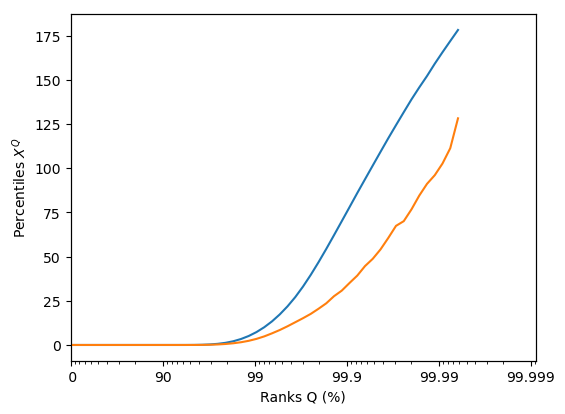

In [41]:
%matplotlib inline
fig,ax = plt.subplots(ncols=1,figsize=(6,4.5))

ranks = dist_Prec.ranks
perc = dist_Prec.percentiles

#--- on IL x axis
ax_show = ax.twiny()

#- set frame
setXaxisIL(ax,ranks)

#- show data
showData(ax_show,ranks,perc, rankmin=0, rankmax = 99.9999)
showData(ax_show, ranks, perc*perc_MCS_over_rain, rankmin=0, rankmax = 99.9999)

#- labels
ax.set_xlabel('Ranks Q (%)')
ax.set_ylabel('Percentiles $X^Q$')

print('check that the curve bounds match')
print('x bounds:',ranks[0],ranks[-1])
print('y bounds:',perc[0],perc[-1])
print()

## And for SAM in Dyamond ? 

In [ ]:
print("Goodbye world !")